Non-Linear Least Squares fitting of XANES Data
=======================================
This Jupyter notebook loads in XANES data from a CSV file into a pandas dataframe and performs a non-linear
least-squares fitting of the selected white-line region using lmfit, which is then removed as background from the 
shoulder peaks. The shoulder peaks are then fit using the lmfit module. The relative peak shift of the Shoulder peak is
then plotted using matplotlib. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from lmfit.models import PseudoVoigtModel, DonaichModel
from random import random, choice
import sys

df = pd.read_csv('./C_20 XANES ASCII Data 2.txt', delimiter='\t')
xlen,ylen = df.shape
ylen = ylen

df2 = pd.read_csv('./C_40 XANES ASCII Data 3.txt', delimiter='\t')
xlen2,ylen2 = df2.shape
ylen2 = ylen2


Graphing of Raw Data
====================

In [2]:
fig = plt.figure()
fig.set_size_inches(15,10.5)
iy = 0
offset = 0
ax = fig.add_subplot(221, facecolor='whitesmoke')
ax.set_title('In Operando XANES of Charging @ C/20')
colors = iter(cm.jet(np.linspace(0, 1, int(ylen/2))))
for iy in range(0,ylen,2):
    # Offset each line by this amount: we want the first lines plotted
    # at the top of the chart and to work our way down
    x = df.iloc[:,iy]
    y = df.iloc[:,iy+1]
    # Plot the line and fill under it: increase the z-order each time
    # so that lower lines and their fills are plotted over higher ones
    ax.set_xlabel('Energy (eV)', color='k')
    ax.set_ylabel('Absorption(a.u.)', color='k')
    ax.set_xlim(7000, 7260)
    #ax.set_ylim(0, 3.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('k') 
    ax.spines['right'].set_color('k')
    ax.spines['left'].set_color('k')
    i = int((iy+1)*2)
    offset = (ylen-iy-2)*0.2
    ax.plot(x, y + offset, color=next(colors), lw=0.5, zorder=i)
    
ax2 = fig.add_subplot(222, facecolor='whitesmoke')
ax2.set_title('In Operando XANES of Charging @ C/40')
color2 = iter(cm.jet(np.linspace(0, 1, int(ylen2/2))))
offset = 0
for iy in range(0,ylen2,2):
    # Offset each line by this amount: we want the first lines plotted
    # at the top of the chart and to work our way down
    x = df2.iloc[:,iy]
    y = df2.iloc[:,iy+1]
    # Plot the line and fill under it: increase the z-order each time
    # so that lower lines and their fills are plotted over higher ones
    ax2.set_xlabel('Energy (eV)', color='k')
    ax2.set_ylabel('Absorption(a.u.)', color='k')
    ax2.set_xlim(7000, 7260)
    #ax2.set_ylim(0, 6)
    ax2.spines['bottom'].set_color('k')
    ax2.spines['top'].set_color('k') 
    ax2.spines['right'].set_color('k')
    ax2.spines['left'].set_color('k')
    i = int((iy+1)*2)
    offset = (ylen2-iy-2)*0.2
    ax2.plot(x, y + offset, color=next(color2), lw=0.5, zorder=i)


Background Fit for Shoulder Peaks
========================
Least-squares fitting of the white-line region for C/20 and C/40 
series with a Donaich spectral function.  This fit is to be used as 
a background function under the shoulder peaks.  It will be removed 
from the signal before the centre position of the shoulder peaks are 
determined. 


Peak: [7095:7130]
Data-Series Chi-Squared
XC0 0.144166809468
X40C1 0.111615477892
X40C2 0.074065224134
X40C3 0.0638748330689
X40C4 0.0599088884826
X40C5 0.0713216003186
X40C6 0.0632684586445
X40C7 0.0679431307935
X40C8 0.0643622675221
X40C9 0.0719315971729
X40C10 0.085644438928
X40C11 0.0703822071494
X40C12 0.0657131991554
Peak: [7095:7130]
Data-Series Chi-Squared


C:\Users\arthurz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


XC0 0.144166809881
X20C1_0_10_4 0.0844264516962
X20C2_0_10_4 0.078933328445
'X20C3_(X20C1_1_16_7)' 0.0690823651437
'X20C4_(X20C2_1_16_7)' 0.0810966421507
X20C5_0_10_4 0.0974587063448
X20C6_0_10_4 0.094885891643
X20C7_0_10_4 0.103569593107


C:\Users\arthurz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


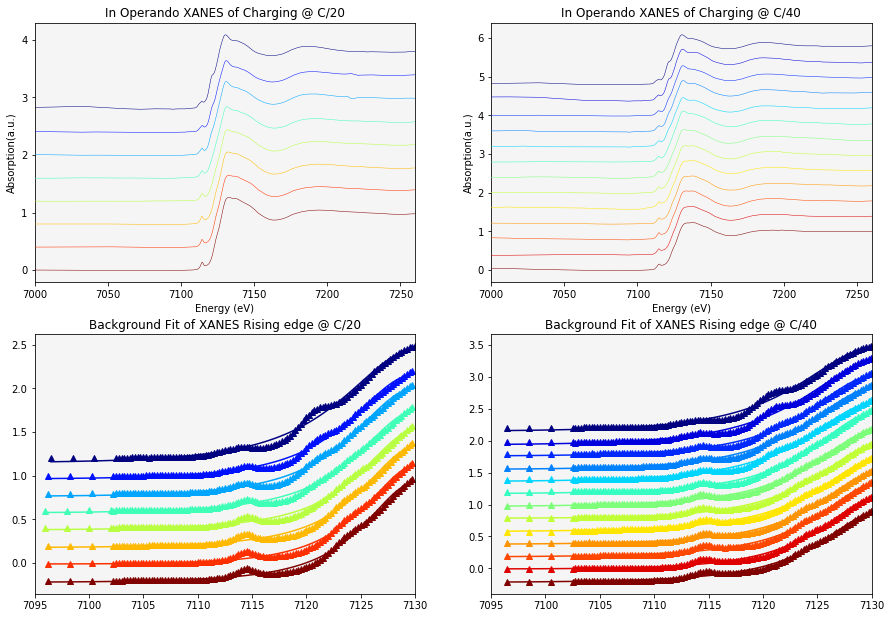

In [3]:
#Select peak regions to fit with DonaichModel
peaks = [(7095,7130)]

#Setup Fit/Result Graphs
ax3 = fig.add_subplot(223, facecolor='whitesmoke')
ax4 = fig.add_subplot(224, facecolor='whitesmoke')
ax4.set_title('Background Fit of XANES Rising edge @ C/40')
ax3.set_title('Background Fit of XANES Rising edge @ C/20')

colors = ['k','r','g','b','c']

result40 = {}
amp = {}
centre = {}
i=0
mean = []
data2={}
for start, stop in peaks:
    i = i + 1
    pk = "peak" + str(i)
    result40[pk] = {}
    amp[pk] = []
    centre[pk] = []
    print("Peak: [%s:%s]" % (start,stop))
    print("Data-Series Chi-Squared")
    #Normalize Colormap to number of items in series
    color2 = iter(cm.jet(np.linspace(0, 1, int(ylen2/2))))
    itr = zip(df2.keys()[0::2], df2.keys()[1::2])
    ct=0
    for ix, iy in itr:
        color = next(color2)
        x40 = df2[(df2[ix] > start)]
        x40 = x40[(df2[ix] < stop)]
        y40 = np.array(x40[iy])
        x40 = np.array(x40[ix])
        #Setup Fit.
        mod = DonaichModel()
        pars = mod.guess(y40, x=x40)
        #Add random noise to the guessed starting parameters. 
        pars['sigma'].set(value = pars['sigma'].value 
                          + random()*2*choice([-1,+1]))
        pars['center'].set(value = pars['center'].value 
                           + random()*10*choice([-1,+1]))
        pars['amplitude'].set(value = pars['amplitude'].value 
                              + random()*10*choice([-1,+1]))
        #Perform Least-Squares Fitting to Data
        result40[pk][ix] = mod.fit(y40, pars, x=x40)
        print(iy, result40[pk][ix].chisqr)
        offset = (ylen2/2-2-ct)*0.2
        ax4.plot(x40, result40[pk][ix].best_fit +offset, color = color)
        ax4.plot(x40, y40 + offset, color = color, marker='^', lw=0, linestyle=None)
        ax4.set_xlim(start, stop)
        ct = ct + 1
        data2[ix] = x40
        data2[iy] = y40 - result40[pk][ix].best_fit

       
result20 = {}
amp = {}
centre = {}
i=0
mean = []
data = {}
for start, stop in peaks:
    i = i + 1
    pk = "peak" + str(i)
    result20[pk] = {}
    amp[pk] = []
    centre[pk] = []
    print("Peak: [%s:%s]" % (start,stop))
    print("Data-Series Chi-Squared")
    itr = zip(df.keys()[0::2], df.keys()[1::2])
    #Normalize Colormap to number of items in series
    color2 = iter(cm.jet(np.linspace(0, 1, int(ylen/2))))
    ct=0
    for ix, iy in itr:
        color = next(color2)
        x20 = df[(df[ix] > start)]
        x20 = x20[(df[ix] < stop)]
        y20 = np.array(x20[iy])
        x20 = np.array(x20[ix])
        #Setup Fit.
        mod = DonaichModel()
        pars = mod.guess(y20, x=x20)
        #Add random noise to the guessed starting parameters. 
        pars['sigma'].set(value = pars['sigma'].value 
                          + random()*2*choice([-1,+1]))
        pars['center'].set(value = pars['center'].value 
                           + random()*10*choice([-1,+1]))
        pars['amplitude'].set(value = pars['amplitude'].value 
                              + random()*10*choice([-1,+1]))
        #Perform Least-Squares Fitting to Data.
        result20[pk][ix] = mod.fit(y20, pars, x=x20)
        print(iy, result20[pk][ix].chisqr)
        offset = (ylen/2 -2-ct)*0.2
        ax3.plot(x20, result20[pk][ix].best_fit +offset, color = color)
        ax3.plot(x20, y20 + offset, color = color, marker='^', 
                 lw=0, linestyle=None)
        ax3.set_xlim(start, stop)
        ct = ct + 1
        data[ix] = x20
        data[iy] = y20 - result20[pk][ix].best_fit

plt.show()

Shoulder Peak Centre Determination
========================
Least-squares fitting of the background subtracted "shoulder peaks" region.   
The fit uses a Psuedo-Voigt model to determine the center of the contribution 
from the starting peak (dipole origins) to the final (quadrupolar) shoulder 
peak upon 1 Li extraction.

Peak: [7118, 7127]
Data-Series Chi-Squared


C:\Users\arthurz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


XC0 0.0314197646169
X20C1_0_10_4 0.130917160409
X20C2_0_10_4 0.246628711505
'X20C3_(X20C1_1_16_7)' 0.206624779267
'X20C4_(X20C2_1_16_7)' 0.162641098158
X20C5_0_10_4 0.159549672701
X20C6_0_10_4 0.173139168827
X20C7_0_10_4 0.16174226514
Peak: [7118, 7127]
Data-Series Chi-Squared

C:\Users\arthurz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



XC0 0.0314177795432
X40C1 0.0380582979605
X40C2 0.204290511144
X40C3 0.157214431404
X40C4 0.16218887157
X40C5 0.220725375502
X40C6 0.175663944503
X40C7 0.178233535213
X40C8 0.192927392505
X40C9 0.157116829716
X40C10 0.188125312513
X40C11 0.18555573811
X40C12 0.179473097204


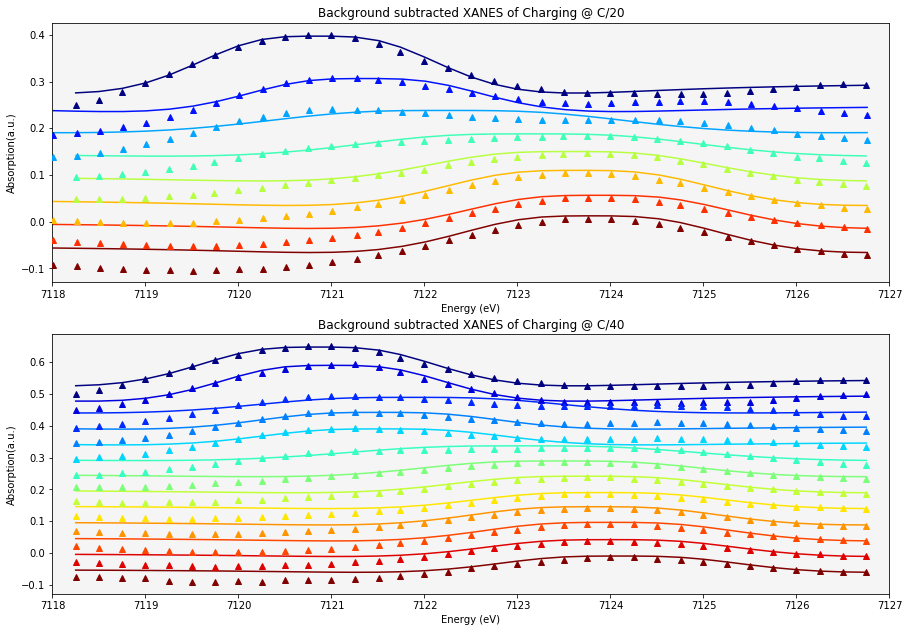

In [4]:

fig2 = plt.figure()
fig2.set_size_inches(15,10.5)
peaks = [(7118,7127)]


offset = 0
bkg = fig2.add_subplot(211, facecolor='whitesmoke')
bkg.set_title('Background subtracted XANES of Charging @ C/20')
itr = zip(df.keys()[0::2], df.keys()[1::2])
sub20 = {}
amp20 = {}
centre20={}
i=0
for start, stop in peaks:
    i = i + 1
    pk = "peak" + str(i)
    print("Peak: [%s, %s]" % (start, stop))
    print("Data-Series Chi-Squared")
    sub20[pk] = {}
    amp20[pk] = []
    centre20[pk] = []
    color2 = iter(cm.jet(np.linspace(0, 1, int(ylen/2))))
    ct=0
    for ix, iy in itr:
        color = next(color2)
        subset = dict(x=data[ix], y= data[iy])
        df = pd.DataFrame(data=subset)
        x20 = df[(df['x'] > start)]
        x20 = x20[(df['x'] < stop)]
        y20 = np.array(x20['y'])
        x20 = np.array(x20['x'])
        sub20[pk][ix] =  y20
        mod = PseudoVoigtModel()
        pars = mod.guess(sub20[pk][ix], x=x20)
        result20[pk][ix] = mod.fit(sub20[pk][ix], pars, x=x20)
        print(iy, result20[pk][ix].params['center'].stderr)
        amp20[pk].append(result20[pk][ix].best_values['amplitude'])
        centre20[pk].append(result20[pk][ix].best_values['center'])
        bkg.set_xlabel('Energy (eV)', color='k')
        bkg.set_ylabel('Absorption(a.u.)', color='k')
        bkg.set_xlim(start, stop)
        #ax.set_ylim(0, 3.5)
        bkg.spines['bottom'].set_color('k')
        bkg.spines['top'].set_color('k') 
        bkg.spines['right'].set_color('k')
        bkg.spines['left'].set_color('k')
        i = i+1
        offset = (ylen/2 -2-ct)*0.05
        bkg.plot(x20, result20[pk][ix].best_fit +offset, color = color)
        bkg.plot(x20, sub20[pk][ix] + offset, color=color, marker='^', 
                 lw=0, zorder=i)
        ct = ct + 1
    
offset = 0
i=0
bkg40 = fig2.add_subplot(212, facecolor='whitesmoke')
bkg40.set_title('Background subtracted XANES of Charging @ C/40')
itr = zip(df2.keys()[0::2], df2.keys()[1::2])
sub40 = {}
amp40 = {}
centre40 = {}
for start, stop in peaks:
    i = i + 1
    pk = "peak" + str(i)
    print("Peak: [%s, %s]" % (start, stop))
    print("Data-Series Chi-Squared")    
    sub40[pk] = {}
    amp40[pk] = []
    centre40[pk] = []
    ct = 0
    color1 = iter(cm.jet(np.linspace(0, 1, int(ylen2/2))))
    for ix, iy in itr:
        color = next(color1)
        subset = dict(x=data2[ix], y=data2[iy])
        df2 = pd.DataFrame(data=subset)
        x40 = df2[(df2['x'] > start)]
        x40 = x40[(df2['x'] < stop)]
        y40 = np.array(x40['y'])
        x40 = np.array(x40['x'])
        sub40[pk][ix] =  y40
        mod = PseudoVoigtModel()
        pars = mod.guess(sub40[pk][ix], x=x40)
        result40[pk][ix] = mod.fit(sub40[pk][ix], pars, x=x40)
        print(iy,result40[pk][ix].params['center'].stderr)
        amp40[pk].append(result40[pk][ix].best_values['amplitude'])
        centre40[pk].append(result40[pk][ix].best_values['center'])
        bkg40.set_xlabel('Energy (eV)', color='k')
        bkg40.set_ylabel('Absorption(a.u.)', color='k')
        bkg40.set_xlim(start, stop)
        #ax.set_ylim(0, 3.5)
        bkg40.spines['bottom'].set_color('k')
        bkg40.spines['top'].set_color('k') 
        bkg40.spines['right'].set_color('k')
        bkg40.spines['left'].set_color('k')
        i = i+1
        offset = (ylen2/2 -2-ct)*0.05
        bkg40.plot(x40, result40[pk][ix].best_fit +offset, color = color)
        bkg40.plot(x40, sub40[pk][ix] + offset, color=color, marker='^', 
                   lw=0, zorder=i)
        ct = ct + 1
plt.show()

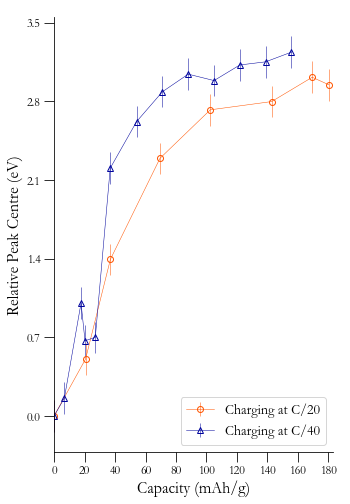

In [5]:
c_20_cap = [0, 20.703, 36.974, 69.513, 102.5, 142.73, 
            169.36, 180.25]
c_40_cap = [0, 6.772, 17.7232, 20.311, 27.082, 36.8549, 54.164, 
            71.09, 88.015, 104.96, 121.87, 138.79, 155.71]

fig3 = plt.figure()
fig3.set_size_inches(5,8)
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'Garamond'})

pkctr = fig3.add_subplot(111, facecolor='white')
pkctr.set_xlabel('Capacity (mAh/g)', color='k', fontsize=16, family='Garamond')
pkctr.set_ylabel('Relative Peak Centre (eV)', color='k', fontsize=16, family='Garamond')
pkctr.spines['top'].set_visible(False)
pkctr.spines['right'].set_visible(False)
pkctr.tick_params('both', length=10, which='major')
pkctr.errorbar(c_20_cap, np.array(centre20['peak1']) - centre20['peak1'][0], yerr=0.14,
           color='#ff5500', marker='o', mfc='none',label='Charging at C/20', lw=0.5)
pkctr.errorbar(c_40_cap, np.array(centre40['peak1']) - centre40['peak1'][0], yerr=0.14,
           color='#00049d', marker='^', mfc='none', label='Charging at C/40', lw=0.5)
pkctr.set_xticks(np.round(np.linspace(0, 180, 10), 1))
pkctr.set_yticks(np.round(np.linspace(0.0, 3.5, 6), 1))
pkctr.set_xlim(0, 183)
pkctr.legend(scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=14)

plt.savefig('Relative_peak_centre.png', bbox_inches='tight', dpi=600)
plt.show()


In [6]:
pd.DataFrame(data={"capacity": c_20_cap ,"pkcentre20": np.array(centre20['peak1']) - centre20['peak1'][0]}).to_csv("covarC20.csv", sep=',')
pd.DataFrame(data={"capacity": c_40_cap ,"pkcentre40": np.array(centre40['peak1']) - centre40['peak1'][0]}).to_csv("covarC40.csv", sep=',')

Error Analysis
==========

Quantifying the error in peak position is difficult to quantify statistically.  The results are conditional upon an approximate fit of the "background" function,  whose origins are a resonant phenomena that is difficult to model absolutely quantitatively.  For the data reported above to be useful,  it need not be absolutely quantitative, but it does need to be self consistent for comparing the two data series.  To test the fit stability, the start parameters were randomized ( see cell 3) and the effect of this "background" function's convergence was tested 10 times; the standard deviation of subsequent results from the Psuedo-Voigt peak centres is calculated as a model dependent error threshold.    

In [459]:
#center_list20_before = [ x - centre20['peak1'][0] 
#                        for x in np.array(centre20['peak1'])]
#center_list40_before = [ x - centre40['peak1'][0] 
#                        for x in np.array(centre40['peak1'])]
#center_list20_1 = [ x - centre20['peak1'][0] 
#                        for x in np.array(centre20['peak1'])]
#center_list40_1 = [ x - centre40['peak1'][0] 
#                        for x in np.array(centre40['peak1'])]
#center_list20_2 = [ x - centre20['peak1'][0] 
#                        for x in np.array(centre20['peak1'])]
#center_list40_2 = [ x - centre40['peak1'][0] 
#                        for x in np.array(centre40['peak1'])]
#center_list20_3 = [ x - centre20['peak1'][0] 
#                        for x in np.array(centre20['peak1'])]
#center_list40_3 = [ x - centre40['peak1'][0] 
#                        for x in np.array(centre40['peak1'])]
#center_list20_4 = [ x - centre20['peak1'][0] 
#                        for x in np.array(centre20['peak1'])]
#center_list40_4 = [ x - centre40['peak1'][0] 
#                        for x in np.array(centre40['peak1'])]
#center_list20_5 = [ x - centre20['peak1'][0] 
#                        for x in np.array(centre20['peak1'])]
#center_list40_5 = [ x - centre40['peak1'][0] 
#                        for x in np.array(centre40['peak1'])]
#center_list20_6 = [ x - centre20['peak1'][0] 
#                        for x in np.array(centre20['peak1'])]
#center_list40_6 = [ x - centre40['peak1'][0] 
#                        for x in np.array(centre40['peak1'])]
#center_list20_7 = [ x - centre20['peak1'][0] 
#                        for x in np.array(centre20['peak1'])]
#center_list40_7 = [ x - centre40['peak1'][0] 
#                        for x in np.array(centre40['peak1'])]
#center_list20_8 = [ x - centre20['peak1'][0] 
#                        for x in np.array(centre20['peak1'])]
#center_list40_8 = [ x - centre40['peak1'][0] 
#                        for x in np.array(centre40['peak1'])]
#center_list20_9 = [ x - centre20['peak1'][0] 
#                        for x in np.array(centre20['peak1'])]
#center_list40_9 = [ x - centre40['peak1'][0] 
#                        for x in np.array(centre40['peak1'])]
center_list20_10 = [ x - centre20['peak1'][0] 
                        for x in np.array(centre20['peak1'])]
center_list40_10 = [ x - centre40['peak1'][0] 
                        for x in np.array(centre40['peak1'])]

[0.0, 0.50776450770354131, 1.3910369863078813, 2.2941360747745421, 2.7254550280676995, 2.7989046564116506, 2.9534939877248689, 2.9482215356401866] [0.0, 0.15875839420550619, 0.99572366145093838, 0.66974131713413954, 0.7009825378027017, 2.2061370461315164, 2.6208328684469961, 2.817501551229725, 3.0430106133462687, 2.9858524563933315, 3.1246779644916387, 3.095963232503891, 3.2389728099988133]


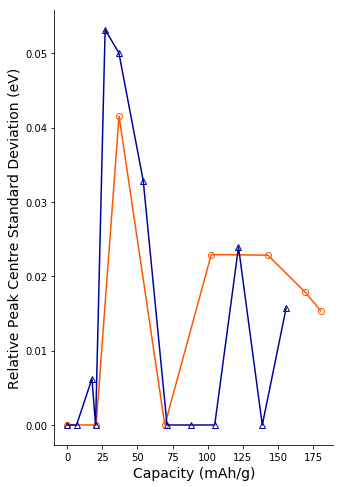

In [514]:
centre_stdev20 = [np.std(x) for x in zip(center_list20_before, 
                                         center_list20_1, 
                                         center_list20_2, 
                                         center_list20_3, 
                                         center_list20_4, 
                                         center_list20_5, 
                                         center_list20_6, 
                                         center_list20_7, 
                                         center_list20_8, 
                                         center_list20_9, 
                                         center_list20_10)]
centre_stdev40 = [np.std(x) for x in zip(center_list40_before, 
                                         center_list40_1, 
                                         center_list40_2, 
                                         center_list40_3, 
                                         center_list40_4, 
                                         center_list40_5, 
                                         center_list40_6, 
                                         center_list40_7, 
                                         center_list40_8, 
                                         center_list40_9, 
                                         center_list40_10)]
centre_20 = pd.DataFrame(data = {x[0]: np.array(x[1:]) 
                                 for x in zip(c_20_cap, 
                                              center_list20_before, 
                                              center_list20_1, 
                                              center_list20_2, 
                                              center_list20_3, 
                                              center_list20_4, 
                                              center_list20_5, 
                                              center_list20_6, 
                                              center_list20_7, 
                                              center_list20_8, 
                                              center_list20_9, 
                                              center_list20_10, 
                                              centre_stdev20)}
                        ).to_csv("C20_shoulder_centre_variance.csv")
centre_40 = pd.DataFrame(data = {x[0]: np.array(x[1:]) 
                                 for x in zip(c_40_cap, 
                                              center_list40_before, 
                                              center_list40_1, 
                                              center_list40_2, 
                                              center_list40_3, 
                                              center_list40_4, 
                                              center_list40_5, 
                                              center_list40_6, 
                                              center_list40_7, 
                                              center_list40_8, 
                                              center_list40_9, 
                                              center_list40_10, 
                                              centre_stdev40)}
                        ).to_csv("C40_shoulder_centre_variance.csv")

fig4 = plt.figure()
fig4.set_size_inches(5,8)

pkctr = fig4.add_subplot(111, facecolor='white')
pkctr.set_xlabel('Capacity (mAh/g)', color='k', fontsize=14)
pkctr.set_ylabel('Relative Peak Centre Standard Deviation (eV)', 
                 color='k', fontsize=14)
pkctr.spines['top'].set_visible(False)
pkctr.spines['right'].set_visible(False)
pkctr.plot(c_20_cap, centre_stdev20, color='#ff5500', 
           marker='o', mfc='none',label='Charging at C/20')
pkctr.plot(c_40_cap, centre_stdev40, color='#00049d', 
           marker='^', mfc='none', label='Charging at C/20')


plt.show()